### Background
Simple numerical integration of the model.

In [1]:
from scipy.integrate import odeint

import numpy as np
import sympy as sp
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def f(x,y,alpha,beta,gamma):
    return -alpha*x + beta*y + gamma*(x**2)*y - gamma*x*(y**2)

def g(x,y,alpha,beta,gamma):
    return alpha*x - beta*y - gamma*(x**2)*y + gamma*x*(y**2)

def E_x(x, mu_x):
    return x*mu_x

def E_y(y, mu_y):
    return y*mu_y

def opinion_model_network(z, t, A, alpha, beta, gamma, mu_x, mu_y):
    omega = np.sum(A, axis=1)

    num_patches = len(z) // 2
    x_ = z[:num_patches]
    y_ = z[num_patches:]

    x = f(x_,y_,alpha, beta, gamma) - omega*E_x(x_, mu_x) + np.sum(A*E_x(x_,mu_x),axis=1)
    y = g(x_,y_,alpha, beta, gamma) - omega*E_y(y_, mu_y) + np.sum(A*E_y(y_,mu_y),axis=1)

    return np.concatenate([x,y])

In [6]:
# Define underlying network structure
A = np.array([[0, 1, 1, 0, 0, 1],
              [1, 0, 1, 0, 1, 0],
              [1, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 1],
              [0, 1, 0, 0, 0, 0],
              [1, 0, 0, 1, 0, 0]])

# Define parameters
alpha = 0.6
beta = 0.8
gamma = 0.02
mu_x = 15
mu_y = 1
M = 15
patches = len(A)
G = nx.from_numpy_array(A)
root_idx = 0 # at which root of x do we evaluate the model

# ODE solve parameters
time = 50
steps = 1 * 10**5

In [7]:
# Find the roots of the system
a = -2*gamma
b = (gamma*M+2*gamma*M)
c = (-alpha-beta-gamma*M**2)
d = beta*M
x = sp.symbols('x')
solution = sp.solve(a*x**3 + b*x**2 + c*x + d, x)
# Get real part of the roots
roots = []
for x in solution:
    if abs(sp.im(x).evalf()) < 10**(-15):
        x = sp.re(x)
    if x.is_real:
        x = float(x)
        roots.append(x)
# Choose root
x_root = roots[root_idx]
y_root = (M-x_root)
print(f"Roots of the system are:{roots}")

Roots of the system are:[4.6802948509750735, 5.0, 12.819705149024927]


In [8]:
# find laplacian
D = np.diag(np.sum(A, axis=1))
L = np.array(D - A)
eigv = np.linalg.eigh(L)[0]
print(f"Lalacian Matrix Eigenvalues are {eigv}")
# Find critical kappa from master stability function
kappa_crit = ((-gamma*y_root**2 + 2*gamma*x_root*y_root - alpha)/mu_x) + ((-gamma*x_root**2 + 2*gamma*x_root*y_root - beta)/mu_y)
print(f'Kappa critical is {kappa_crit}')
print(f'Is any of laplacian eigenvalues below kappa_crit? {any(value < kappa_crit for value in eigv)}')

Lalacian Matrix Eigenvalues are [-8.64942582e-16  4.13094016e-01  1.13693295e+00  2.35947024e+00
  3.69774655e+00  4.39275625e+00]
Kappa critical is 0.6406702655709678
Is any of laplacian eigenvalues below kappa_crit? True


In [9]:
# initial values
noise = -0.5 + np.random.uniform(0, 1, size=A.shape[0])
x0 = np.full(A.shape[0], x_root) + noise
y0 = np.full(A.shape[0], y_root) - noise
z0 = np.concatenate([x0, y0])
# solve System
t = np.linspace(0, time, steps)
exact_solution = odeint(opinion_model_network, z0, t, args=(A, alpha, beta, gamma, mu_x, mu_y))

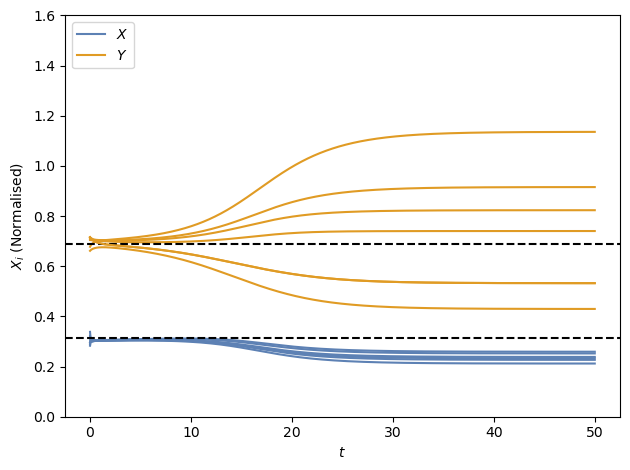

In [10]:
# Plot Results
x_result = exact_solution[:, :A.shape[0]]/M
y_result = exact_solution[:, A.shape[0]:]/M

for i in range(0, A.shape[0]):
    plt.plot(t, x_result[:,i], color="#5d81b4", linestyle="-")
    plt.plot(t, y_result[:,i], color="#e09b24", linestyle="-")
plt.axhline(x_root/M, color="black", linestyle="--")
plt.axhline(y_root/M, color="black", linestyle="--")
plt.plot(t, y_result[:,i], color="#e09b24", linestyle="-")
plt.xlabel(r'$t$')
plt.ylabel(r'$X_i$ (Normalised)')
plt.ylim([0,1.6])
red_patch = plt.Line2D([0], [0], color='#5d81b4', linestyle='-', label=r'$X$')
blue_patch = plt.Line2D([0], [0], color='#e09b24', linestyle='-', label=r'$Y$')
plt.legend(handles=[red_patch, blue_patch], loc="upper left")
plt.tight_layout()
plt.show()

#### Figure 1: Network structure

In [11]:
# Get the abundances of each opinion on every node at the last time step
x_abundance = exact_solution[-1,:patches]
y_abundance = exact_solution[-1,patches:]
variable_1 = {i: x_abundance[i] for i in G.nodes()}
variable_2 = {i: y_abundance[i] for i in G.nodes()}

# Calculate proportions
total_abundance = {i: variable_1[i] + variable_2[i] for i in G.nodes()}
proportion_variable_1 = {i: variable_1[i] / total_abundance[i] for i in G.nodes()}
proportion_variable_2 = {i: variable_2[i] / total_abundance[i] for i in G.nodes()}

max_abundance = M
node_sizes = [(total_abundance[i] / max_abundance) for i in G.nodes()]

(np.float64(-1.660798251946858),
 np.float64(0.839201748053142),
 np.float64(-1.8027628796425996),
 np.float64(0.6972371203574004))

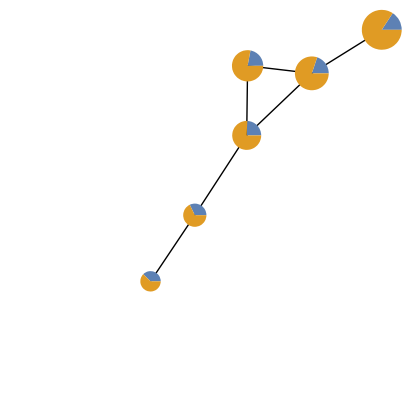

In [12]:
# plot the network
spring_positions = nx.spring_layout(G, seed=11)
ax = plt.gca()
nx.draw_networkx(G, spring_positions, node_size=0, node_color="black", with_labels=False)
for node in G.nodes():
    size = node_sizes[node] / 10  # Adjust size for pie chart
    p1 = proportion_variable_1[node]
    p2 = proportion_variable_2[node]
    # Pie chart properties
    ax.pie(
        [p1,p2],
        center=spring_positions[node], 
        colors = [mpl.colors.to_rgb("#5d81b4"), mpl.colors.to_rgb("#e09b24")],
        radius=size,
        wedgeprops = {'linewidth': 5})
plt.axis("off")